In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from utils import *
# Ignore all warnings
warnings.filterwarnings("ignore")
import os
import ast
from tqdm import tqdm
# from mayavi import mlab



<h2> Process the Metadata

In [2]:
path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/autoPETmeta.csv'
raw_meta_df = pd.read_csv(path)
raw_meta_df.fillna('unknown', inplace=True)
raw_meta_df[['patient_id','study_id']] = raw_meta_df['study_location'].str.rsplit('/', n=2, expand=True)[[0,1]]
raw_meta_df['patient_id'] = raw_meta_df['patient_id'].str.split('/').str[-1]

def get_diagnosis(raw_meta_df = raw_meta_df):
    raw_df = raw_meta_df.copy()
    diagnosis_dict = {(row['patient_id'], row['study_id']): row['diagnosis'] for index, row in raw_df.iterrows()}
    return diagnosis_dict

def read_diagnosis_sample_patient_id(raw_meta_df = raw_meta_df,diagnosis = "NEGATIVE"):
    raw_df = raw_meta_df.copy()

    diagnosis_id_lst = raw_df[raw_df['diagnosis'] == diagnosis]['patient_id']
    diagnosis_study_lst = raw_df[raw_df['diagnosis'] == diagnosis]['study_id']
    return diagnosis_id_lst, diagnosis_study_lst


In [3]:
patient_study_counts = raw_meta_df.groupby('patient_id')['study_id'].nunique()
patients_with_multiple_studies = patient_study_counts[patient_study_counts > 1]

# The length of this filtered series gives us the number of Patient IDs with more than 1 unique Study ID
number_of_patients_more_than_1_study = len(patients_with_multiple_studies)
number_of_patients_more_than_1_study
print(f'There are {number_of_patients_more_than_1_study} patients with more than 1 study.')

There are 81 patients with more than 1 study.


In [4]:
# Find patients with negative diagnosis
negative_patients = set(raw_meta_df[raw_meta_df['diagnosis'] == 'NEGATIVE']['patient_id'])

# Find patients with positive diagnosis
positive_patients = set(raw_meta_df[raw_meta_df['diagnosis'] != 'NEGATIVE']['patient_id'])

# Find patients that are in both negative diagnosis and other positive diagnosis
cross_diagnosis_patients = negative_patients.intersection(positive_patients)

cross_diagnosis_patients
print(f"Number of patients that have more than 1 diagnosis: {len(cross_diagnosis_patients)}")

Number of patients that have more than 1 diagnosis: 30


In [5]:
diagnosis_dict = get_diagnosis(raw_meta_df = raw_meta_df)

In [6]:
negative_id_lst, negative_study_lst = read_diagnosis_sample_patient_id()

In [8]:
from sklearn.model_selection import train_test_split
path = '../all_patients_sample_size_100_for_both_pos_neg.csv'
raw_df = pd.read_csv(path)
print(f'raw_df shape: {raw_df.shape}')
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900-1
num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014-1

remove_all_0s = raw_df[~(raw_df['Block Size'] == '0')]
print(remove_all_0s.shape)
# Load the dataset
df = remove_all_0s.reset_index(drop = True)

# First split: Separate out the test set
train_val_idx, test_idx = train_test_split(df.index, test_size=0.2, stratify=df['Positive Tumor'], random_state=42)
# Second split: Split the remaining data into training and validation sets
train_val_df = df.loc[train_val_idx]
test_df = df.loc[test_idx]
train_idx, valid_idx = train_test_split(train_val_idx, test_size=0.25, stratify=train_val_df['Positive Tumor'], random_state=42)
train_df = df.loc[train_idx]
val_df = df.loc[valid_idx]

raw_df shape: (152076, 6)
(151134, 6)


In [11]:
features = np.load("../ori_reso_all_dataset.npy", allow_pickle=True)
print(features.shape)
labels =np.load("../ori_reso_all_labels.npy", allow_pickle=True)
print(labels.shape)

(151134, 3, 3, 3)
(151134,)


In [14]:
labels[train_val_idx].sum()

39867

In [9]:
train_df

,Patient ID,Study ID,Tumor idx,Coordinate,Block Size,Positive Tumor
87934,PETCT_9a418f3b3a,05-11-2003-NA-PET-CT Ganzkoerper primaer mit ...,52,"(157,201,217)","(3,3,3)",0
60035,PETCT_6543c58e13,02-25-2001-NA-PET-CT Ganzkoerper primaer mit ...,37,"(221,195,212)","(3,3,3)",2
31671,PETCT_390129c0d2,04-27-2007-NA-PET-CT Ganzkoerper primaer mit ...,76,"(224,185,320)","(3,3,3)",0
12465,PETCT_17d334cb6c,08-28-2000-NA-Unspecified CT ABDOMEN-62383,86,"(153,191,206)","(3,3,3)",2
130775,PETCT_dc15c1d9bb,06-03-2005-NA-PET-CT Ganzkoerper primaer mit ...,73,"(209,256,272)","(3,3,3)",0
...,...,...,...,...,...,...
73339,PETCT_7e5729ea40,02-21-2003-NA-PET-CT Ganzkoerper primaer mit ...,98,"(218,215,318)","(3,3,3)",0
25232,PETCT_2f587d00b1,09-27-2004-NA-Unspecified CT-22169,35,"(177,208,318)","(3,3,3)",0
117389,PETCT_ca58410fad,05-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,71,"(184,193,237)","(3,3,3)",2
78887,PETCT_8a52353a72,02-17-2003-NA-PET-CT Ganzkoerper primaer mit ...,136,"(126,187,51)","(3,3,3)",2


In [18]:
# only need to run for once.
# import csv
# input_file_path =  '../all_patients_tumor_pos_neg_block.csv'
# output_file_path = '../corrected_all_patients_tumor_pos_neg_block.csv'


# with open(input_file_path, 'r') as infile, open(output_file_path, 'w', newline='') as outfile:
#     reader = csv.reader(infile)
#     writer = csv.writer(outfile)

#     # Write the header without modification
#     writer.writerow(next(reader))

#     # Iterate over each row in the original CSV
#     for row in reader:
#         # Skip rows that do not have the expected number of elements
#         # Assuming the full row should have more than 6 elements due to 'Coordinate' and 'Block Size'
#         if len(row) <= 6:
#             continue  # Skip this row

#         # Assuming the 'Coordinate' starts at index 3 and 'Block Size' immediately follows
#         # and checking if row has enough elements to avoid IndexError
#         if len(row) >= 9:  # Ensure there are enough elements for 'Coordinate' and 'Block Size'
#             coordinate = ','.join(row[3:6])  # Merge the coordinate parts
#             block_size = ','.join(row[6:9])  # Merge the block size parts
#             # Reconstruct the row with merged 'Coordinate' and 'Block Size'
#             corrected_row = row[:3] + [coordinate, block_size] + row[9:]
#         else:
#             # If the row does not have enough elements after the 'Tumor idx', skip it
#             continue

#         # Write the corrected row to the new file
#         writer.writerow(corrected_row)

# print(f"Corrected CSV file has been saved to: {output_file_path}")



Corrected CSV file has been saved to: ../corrected_all_patients_tumor_pos_neg_block.csv


In [7]:
# path = '../corrected_all_patients_tumor_pos_neg_block.csv'
path = '../all_patients_sample_size_100_for_both_pos_neg.csv'
# path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
print(f'raw_df shape: {raw_df.shape}')
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900-1

num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014-1

# Create a new column called 'Diagnosis' in the raw_df
tuples = list(zip(raw_df['Patient ID'], raw_df['Study ID']))
# Now map these tuples to their corresponding diagnosis using the diagnosis_dict
raw_df['Diagnosis'] = pd.Series(tuples).map(diagnosis_dict)


raw_df shape: (152076, 6)


In [10]:
raw_df

,Patient ID,Study ID,Tumor idx,Coordinate,Block Size,Positive Tumor,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,0,0,0,0,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,0,"(225,270,300)","(3,3,3)",2,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,"(133,267,296)","(3,3,3)",2,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,"(136,271,294)","(3,3,3)",2,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,"(231,277,294)","(3,3,3)",2,MELANOMA
...,...,...,...,...,...,...,...
152071,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,95,"(116,263,495)","(3,3,3)",0,NEGATIVE
152072,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,96,"(171,130,307)","(3,3,3)",0,NEGATIVE
152073,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,97,"(154,196,304)","(3,3,3)",0,NEGATIVE
152074,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,98,"(232,175,272)","(3,3,3)",0,NEGATIVE


In [8]:
raw_df['Positive Tumor'].value_counts()

Positive Tumor
0    102242
2     49344
1       490
Name: count, dtype: int64

In [9]:
remove_all_0s = raw_df[~(raw_df['Block Size'] == '0')]

In [10]:
remove_all_0s

,Patient ID,Study ID,Tumor idx,Coordinate,Block Size,Positive Tumor,Diagnosis
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,0,"(225,270,300)","(3,3,3)",2,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,"(133,267,296)","(3,3,3)",2,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,"(136,271,294)","(3,3,3)",2,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,"(231,277,294)","(3,3,3)",2,MELANOMA
5,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,"(226,275,301)","(3,3,3)",2,MELANOMA
...,...,...,...,...,...,...,...
152071,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,95,"(116,263,495)","(3,3,3)",0,NEGATIVE
152072,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,96,"(171,130,307)","(3,3,3)",0,NEGATIVE
152073,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,97,"(154,196,304)","(3,3,3)",0,NEGATIVE
152074,PETCT_ff39795341,09-22-2005-NA-PET-CT Ganzkoerper primaer mit ...,98,"(232,175,272)","(3,3,3)",0,NEGATIVE


In [16]:
raw_df['Positive Tumor'].value_counts()

Positive Tumor
0    102242
2     49344
1       490
Name: count, dtype: int64

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = remove_all_0s

# First split: Separate out the test set
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Positive Tumor'], random_state=42)

# Second split: Split the remaining data into training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['Positive Tumor'], random_state=42)
# Note: 0.25 in the second split results in 20% of the original data because 0.25 * 0.8 = 0.2

# You now have train_df, val_df, and test_df


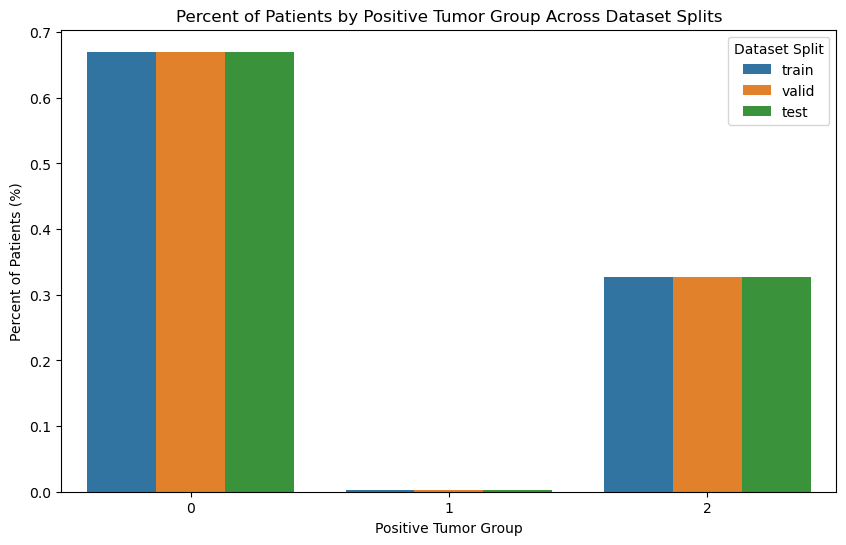

In [12]:
# Check the distribution across the splits
distribution = {
    'train': train_df['Positive Tumor'].value_counts(normalize=True),
    'valid': val_df['Positive Tumor'].value_counts(normalize=True),
    'test': test_df['Positive Tumor'].value_counts(normalize=True)
}

# Convert the distribution into a DataFrame for plotting
distribution_df = pd.DataFrame(distribution).reset_index()
distribution_df.columns = ['Group', 'train', 'valid', 'test']
distribution_df = distribution_df.melt(id_vars='Group', var_name='Dataset Split', value_name='Percent of Patients')

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.title('Percent of Patients by Positive Tumor Group Across Dataset Splits')
sns.barplot(data=distribution_df, x='Group', y='Percent of Patients', hue='Dataset Split')
plt.xlabel('Positive Tumor Group')
plt.ylabel('Percent of Patients (%)')
plt.show()

In [13]:
# create inputs for model:
def create_inputs(df, split, raw_all_data_directory = "/Volumes/T7 Shield/IBM/FDG-PET-CT-Lesions"):
    raw_input_data = []  # List to collect data for raw_input_df
    raw_input_label = []
    scale_up_input_data = []  # List to collect data for scale_up_input_df
    scale_up_input_label = []
    # count = 0
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        patient_path = os.path.join(raw_all_data_directory, row['Patient ID'], row['Study ID'])
        block_coorindate = ast.literal_eval(row['Coordinate'])
        block_coorindate = tuple(map(int, block_coorindate))
        block_size = ast.literal_eval(row['Block Size'])
        block_size = tuple(map(int, block_size))
        
        # print(block_size[0])
        # break
        suv_path = os.path.join(patient_path, 'SUV.nii.gz')
        seg_path = os.path.join(patient_path, 'SEG.nii.gz')
        seg_data = nib.load(seg_path).get_fdata()
        suv_data = nib.load(suv_path).get_fdata()
        label = row['Positive Tumor']
        
        # seg_block = seg_data[int(block_coorindate[0]):block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
        # assert np.sum(seg_block) > 0, f"Positive block has no tumor in {patient_path}"
        # assert np.sum(seg_block) == 0, f"Negative block has tumor in {patient_path}"

        # Prepare label
        label = 0 if int(label) == 0 else 1
        suv_block = suv_data[block_coorindate[0]:block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
        raw_input_data.append(suv_block)
        raw_input_label.append(label)

        scale_up_suv_block = scale_up_block(suv_block, new_resol= [224,224,224])
        scale_up_input_data.append(scale_up_suv_block)
        scale_up_input_label.append(label)
   
        
        # # Append data to the lists
        # raw_input_data.append({'SUV_Block': suv_block, 'label': label})
        # print(len(raw_input_data))
        # scale_up_input_data.append({'SUV_Block': scale_up_suv_block, 'label': label})
        # if index == 2:
        # count += 1
        # if count == 2:
        # break
    # Convert lists to DataFrames
    # raw_input_df = pd.DataFrame(raw_input_data)
    # scale_up_input_df = pd.concat([pd.DataFrame(scale_up_input_data)], ignore_index=True)
    np.save(f'{split}_original_reso_dataset.npy', raw_input_data)
    np.save(f'{split}_original_reso_labels.npy', raw_input_label)


    np.save(f'{split}_scale_up_reso_dataset.npy', scale_up_input_data)
    np.save(f'{split}_scale_up_reso_labels.npy', scale_up_input_label)
    return {'raw_input_df': raw_input_data, 'raw_input_label': raw_input_label, 'scale_up_input_df': scale_up_input_data, 'scale_up_input_label': scale_up_input_label}
    # return {'raw_input_df': raw_input_data, 'scale_up_input_df': scale_up_input_data}

    # print(row['Block Size'])
    # break
    

In [16]:
# import os
# import pandas as pd
# import ast


# # Assuming df is your DataFrame with 'Patient ID' and 'Study ID' columns
# # df = pd.read_csv('path_to_your_dataframe.csv')  # Uncomment and modify this line if you need to read the DataFrame from a file

# raw_all_data_directory = "/Volumes/T7 Shield/IBM/FDG-PET-CT-Lesions"
# count = 0
# # Loop through the DataFrame and construct paths
# # for index, row in positive_block_df.iterrows():
# for index, row in negative_block_df.iterrows():

#     # Construct the path for each row
#     # It's important to remove any trailing characters like '...' that may not actually be part of the directory name
#     # Adapt this line if the split pattern is different
#     patient_path = os.path.join(raw_all_data_directory, row['Patient ID'], row['Study ID'])
#     block_coorindate = ast.literal_eval(row['Coordinate'])
#     block_coorindate = tuple(map(int, block_coorindate))
#     block_size = ast.literal_eval(row['Block Size'])
#     block_size = tuple(map(int, block_size))
    
#     # print(block_size[0])
#     # break
#     suv_path = os.path.join(patient_path, 'SUV.nii.gz')
#     seg_path = os.path.join(patient_path, 'SEG.nii.gz')
#     seg_data = nib.load(seg_path).get_fdata()
#     suv_data = nib.load(suv_path).get_fdata()
    
#     seg_block = seg_data[int(block_coorindate[0]):block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
#     # assert np.sum(seg_block) > 0, f"Positive block has no tumor in {patient_path}"
#     assert np.sum(seg_block) == 0, f"Negative block has tumor in {patient_path}"
#     suv_block = suv_data[block_coorindate[0]:block_coorindate[0]+block_size[0], block_coorindate[1]:block_coorindate[1]+block_size[1], block_coorindate[2]:block_coorindate[2]+block_size[2]]
   
#     # mlab.figure(bgcolor=(0, 0, 0), size=(400, 400))
#     # mlab.title('Original SUV Block')
#     # mlab.contour3d(suv_block, contours=8, transparent=True)
#     # mlab.colorbar(orientation='vertical')
#     # mlab.outline(color=(1, 1, 1))
#     # mlab.show()

#     scale_up_suv_block = (scale_up_block(suv_block, new_resol= [224,224,224]))
#     # Visualization of the scaled SUV block
#     mlab.figure(bgcolor=(0, 0, 0), size=(400, 400))
#     mlab.title('Scaled SUV Block')
#     mlab.contour3d(scale_up_suv_block, contours=8, transparent=True)
#     mlab.colorbar(orientation='vertical')
#     mlab.outline(color=(1, 1, 1))
#     mlab.show()
#     break

   


Current object is not active, please select an active object.


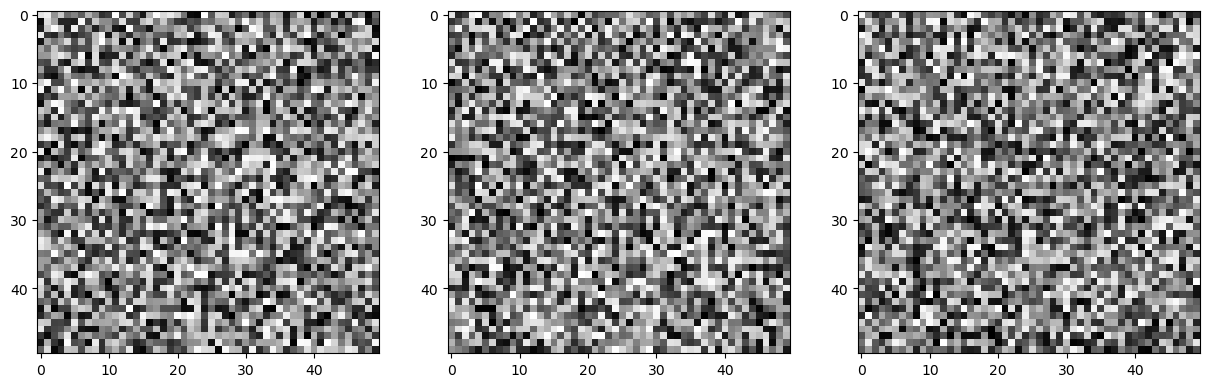

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `block` is your 3D numpy array
block = np.random.rand(3, 3, 3)  # Example data

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display slices of the block
axs[0].imshow(block[0, :, :], cmap='gray')  # Middle slice on the x-axis
axs[1].imshow(block[:, 0, :], cmap='gray')  # Middle slice on the y-axis
axs[2].imshow(block[:, :, 0], cmap='gray')  # Middle slice on the z-axis

plt.show()


In [4]:
import numpy as np
a = np.empty(0)

In [5]:
np.append(a, [1])

array([1.])